In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import chi2_contingency
import math
from collections import Counter
from scipy.stats import entropy
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from numpy import inf
from sklearn.model_selection import GridSearchCV



In [2]:
# Load the train and test datasets
Xtrain_scaled = np.load('Xtrain_scaled.npy')
Xtest_scaled = np.load('Xtest_scaled.npy')
Xtrainb_scaled = np.load('Xtrainb_scaled.npy')
Xtestb_scaled = np.load('Xtestb_scaled.npy')
ytrain = np.load('ytrain.npy')
ytest = np.load('ytest.npy')
df_train = pd.read_csv('../paths_CYF_trainData.csv')
df_test = pd.read_csv('../paths_CYF_testData.csv')


In [3]:
# Initial variables for the model. 
# I focus exclusively on the pre services and loc plus demographics with less than 20% of missing data.

id_cols = ['id', 'client_id']

demo_cols = ['age', 'age_group','race','gender','dx_group','lang', 'substance','insurance','liv']

ip_cols = ['as_loc', 'as_length_IP', 'IP_history', 'as_close']

loc_pre_cols = ['loc1_pre', 'loc2_pre', 'loc3_pre', 'loc4_pre', 'loc5_pre']

svc_total_pre_cols = ['svc_pre_all', 'svc_pre', 'svc_pre_sub']

svc_CYF_timepoint_pre_cols = ['svc_op_7days_pre', 'svc_op_30days_pre', 'svc_op_60days_pre', 'svc_op_90days_pre',
                     'svc_es_7days_pre', 'svc_es_30days_pre', 'svc_es_60days_pre', 'svc_es_90days_pre',
                     'svc_dt_7days_pre', 'svc_dt_30days_pre', 'svc_dt_60days_pre', 'svc_dt_90days_pre',
                     'svc_ip_7days_pre', 'svc_ip_30days_pre', 'svc_ip_60days_pre', 'svc_ip_90days_pre']

output_col = ['svc_CYF_ip_30days_postdc_bi']

drop_cols = ['']

In [6]:
numerical_features = ['age', 'as_length_IP', 'IP_history', 'svc_pre_all', 'svc_pre', 'svc_pre_sub']
numerical_features = numerical_features  + svc_CYF_timepoint_pre_cols
dummy_vars = df_train.loc[:, 'age_group_12-15 Yrs':'loc5_pre_WRAP']
dummy_vars = list(dummy_vars.columns)
categorical_features = dummy_vars + ['substance', 'new','CWS', 'ADS', 'JJ']
all_features = numerical_features + categorical_features

boruta_features = ['as_length_IP', 'IP_history', 'svc_pre_all', 'svc_pre', 'svc_op_30days_pre', 'svc_es_30days_pre', 'svc_ip_7days_pre', 'svc_ip_30days_pre', 'as_loc_IPCAPS', 'as_loc_IPFFS', 'as_close_Home/Shelter/Self', 'as_close_Satisfactorily Achieved\r\nGoals']

In [7]:
Xtrain = df_train[all_features]
Xtrainb = df_train[boruta_features]

In [8]:
# Set a seed for reproducibility
SEED = 300
np.random.seed(SEED)

In [9]:
print(np.any(np.isnan(Xtrain_scaled)))
print(np.any(np.isnan(ytrain)))
#np.all(np.isfinite(Xtrain_scaled))

False
False


In [10]:
print(np.any(np.isnan(Xtest_scaled)))
print(np.any(np.isnan(ytest)))

False
False


### Fit all variables into the models

In [11]:
# import datetime
from datetime import datetime

# import a host of Scikit-learn models
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

# import model metrics
from sklearn.metrics import *


def get_models():
    """Generate a library of base learners."""
    nb = GaussianNB()
    knn = KNeighborsClassifier(n_neighbors=3)
    lr = LogisticRegression(C=1, random_state=SEED, solver='liblinear', class_weight='balanced')
    nn = MLPClassifier((100, 50), early_stopping=True, random_state=SEED, max_iter=400, activation='tanh')
    dt = DecisionTreeClassifier(random_state=SEED, class_weight='balanced')
    rf = RandomForestClassifier(n_estimators=100, random_state=SEED, class_weight='balanced')
    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
    
    models = {'naive bayes': nb,
              'knn': knn,
              'logistic': lr,
              'mlp-nn': nn,
              'decision tree': dt,
              'random forest': rf,
              'gbm': gb
             }

    return models


def train_predict(model_list, xtrain, ytrain, xtest):
    """Fit models in list on training set and return preds"""
    P = np.zeros((ytest.shape[0], len(model_list)))
    P = pd.DataFrame(P)
    
    S = np.zeros((ytest.shape[0], len(model_list)))
    S = pd.DataFrame(S)
    
    print("Fitting models.")
    cols = list()
    model_cvs = {}

    for i, (name, m) in enumerate(models.items()):
        current_time = datetime.now() 
        print("%s..." % name, end=" ", flush=False)
        model_cvs[name] = m.fit(xtrain, ytrain)
        m.fit(xtrain, ytrain)
        P.iloc[:, i] = m.predict_proba(xtest)[:, 1]
        S.iloc[:, i] = m.predict(xtest)
        cols.append(name)
        time_elapsed = datetime.now() - current_time
        print("Time elapsed ", time_elapsed)
        print("done")

    P.columns = cols
    S.columns = cols
    
    print("Done.\n")
    return P, S, model_cvs

    
def evaluate(y_true, S, P):
    for m in P.columns:
        y_pred = S.loc[:, m]
        y_pred_proba = P.loc[:, m]
        acc = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1score = f1_score(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred_proba)
        ap = average_precision_score(y_true, y_pred_proba)
        print ("Accuracy : {:.4f}".format(acc))
        print("Precision : {:.4f}".format(precision))
        print("Recall : {:.4f}".format(recall))
        print("F1 score : {:.4f}".format(f1score))
        print("AUC score : {:.4f}".format(auc))
        print("AP score : {:.4f}".format(ap))
        print("\nClassification report : \n", classification_report(y_true, y_pred))
        print("\nConfusion matrix : \n", confusion_matrix(y_true, y_pred))
        print("done.\n")  
    return acc, precision, recall, f1score, auc, ap

In [12]:
models = get_models()
P, S, model_cvs = train_predict(models, Xtrain_scaled, ytrain, Xtest_scaled)
evaluate(ytest, S, P)

Fitting models.
naive bayes... Time elapsed  0:00:00.232004
done
knn... Time elapsed  0:00:40.372992
done
logistic... Time elapsed  0:00:00.956002
done
mlp-nn... Time elapsed  0:00:56.658002
done
decision tree... Time elapsed  0:00:03.103010
done
random forest... Time elapsed  0:00:19.531988
done
gbm... Time elapsed  0:01:02.093995
done
Done.

Accuracy : 0.3871
Precision : 0.3207
Recall : 0.9252
F1 score : 0.4763
AUC score : 0.6744
AP score : 0.4373

Classification report : 
               precision    recall  f1-score   support

           0       0.83      0.16      0.26      1953
           1       0.32      0.93      0.48       842

    accuracy                           0.39      2795
   macro avg       0.57      0.54      0.37      2795
weighted avg       0.68      0.39      0.33      2795


Confusion matrix : 
 [[ 303 1650]
 [  63  779]]
done.

Accuracy : 0.6608
Precision : 0.4572
Recall : 0.6722
F1 score : 0.5442
AUC score : 0.6916
AP score : 0.4419

Classification report : 
  

(0.7903398926654741,
 0.6807909604519774,
 0.5724465558194775,
 0.6219354838709678,
 0.8292787270451818,
 0.7290372488027012)

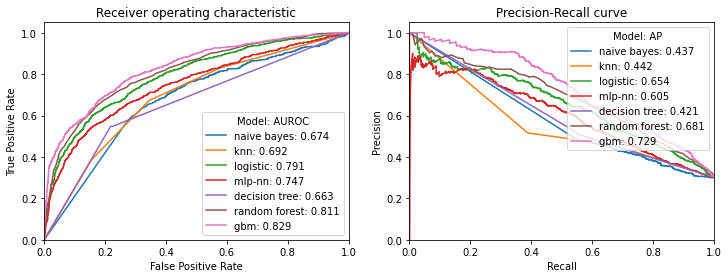

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))    
for column in P.columns:
    roc_auc = roc_auc_score(ytest, P[column])
    fpr, tpr, _ = roc_curve(ytest, P[column])
    ax[0].plot(fpr, tpr, label='%s: %0.3f' % (column, roc_auc))

    precision, recall, _ = precision_recall_curve(ytest, P[column])
    ave_prec_rec = average_precision_score(ytest, P[column])
    ax[1].plot(recall, precision, label='%s: %0.3f' % (column, ave_prec_rec))  

    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver operating characteristic')
    ax[0].legend(loc="lower right", title="Model: AUROC")

    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall curve')
    ax[1].legend(loc="upper right", title="Model: AP")
   
#plt.savefig('mult_models_after_feat_select.png', format='png')

In [14]:
lr_importances = pd.Series(model_cvs['logistic'].coef_[0], index=Xtrain.columns, name = 'LR')
lr_importances_abs = pd.Series(abs(model_cvs['logistic'].coef_[0]), index=Xtrain.columns, name = 'LR')
print("Top 15 features")
print(lr_importances.nlargest(15))

Top 15 features
svc_ip_60days_pre                3.177785
svc_ip_90days_pre                2.244554
as_close_Psychiatric Hospital    1.953391
loc2_pre_DTCTF                   1.749187
svc_ip_30days_pre                1.666458
IP_history                       1.584011
loc4_pre_CS                      1.256464
loc1_pre_CM                      1.183610
loc3_pre_ESU                     1.087095
as_close_Homeless                1.014431
loc5_pre_PREV                    0.947296
as_close_Medical Hospital        0.915874
svc_es_90days_pre                0.867926
loc5_pre_CR                      0.851023
dx_group_Other/ Excluded         0.814720
Name: LR, dtype: float64


In [15]:
dt_importances = pd.Series(model_cvs['decision tree'].feature_importances_, index=Xtrain.columns, name = 'DT')
print("Top 15 features")
print(dt_importances.nlargest(15))

Top 15 features
as_length_IP         0.143153
svc_ip_90days_pre    0.132238
IP_history           0.116149
as_loc_IPFFS         0.049412
as_loc_IPCAPS        0.033252
svc_ip_60days_pre    0.028346
age                  0.026674
svc_pre_all          0.026284
svc_pre              0.025880
svc_pre_sub          0.022663
svc_es_30days_pre    0.019248
svc_op_90days_pre    0.018876
svc_op_60days_pre    0.017379
svc_es_90days_pre    0.014969
svc_op_7days_pre     0.014676
Name: DT, dtype: float64


In [16]:
rf_importances = pd.Series(model_cvs['random forest'].feature_importances_, index=Xtrain.columns, name = 'RF')
print("Top 15 features")
print(rf_importances.nlargest(15))

Top 15 features
as_length_IP         0.083843
IP_history           0.051858
svc_ip_90days_pre    0.040497
as_loc_IPFFS         0.038284
svc_pre_all          0.033630
age                  0.033194
svc_ip_60days_pre    0.031673
svc_pre              0.030669
svc_es_60days_pre    0.029024
svc_op_90days_pre    0.028554
as_loc_IPCAPS        0.026751
svc_op_60days_pre    0.026385
svc_es_90days_pre    0.026199
svc_op_30days_pre    0.026013
svc_ip_30days_pre    0.025282
Name: RF, dtype: float64


In [17]:
gbm_importances = pd.Series(model_cvs['gbm'].feature_importances_, index=Xtrain.columns, name = 'GBM')
print("Top 15 features")
print(gbm_importances.nlargest(15))

Top 15 features
as_length_IP                  0.207489
IP_history                    0.128825
svc_ip_90days_pre             0.125523
as_loc_IPFFS                  0.106412
as_loc_IPCAPS                 0.091033
svc_ip_60days_pre             0.072152
svc_ip_7days_pre              0.044465
svc_pre_sub                   0.037903
svc_op_7days_pre              0.031185
age                           0.029213
as_close_Home/Shelter/Self    0.023523
svc_es_30days_pre             0.013815
insurance_Other Insurance     0.013686
svc_ip_30days_pre             0.012548
svc_es_60days_pre             0.011022
Name: GBM, dtype: float64


In [18]:
importances_df = pd.concat([lr_importances, dt_importances, rf_importances, gbm_importances], axis=1)
importances_df['avg'] = importances_df[['DT', 'RF', 'GBM']].mean(axis=1)
importances_df = importances_df.sort_values(by='avg', ascending=False)
importances_df.reset_index(inplace=True)
importances_df = importances_df.rename(columns = {'index':'Variable'})
importances_df.head(15)

,Variable,LR,DT,RF,GBM,avg
0,as_length_IP,-0.385998,0.143153,0.083843,0.207489,0.144828
1,svc_ip_90days_pre,2.244554,0.132238,0.040497,0.125523,0.099419
2,IP_history,1.584011,0.116149,0.051858,0.128825,0.098944
3,as_loc_IPFFS,-2.752748,0.049412,0.038284,0.106412,0.064703
4,as_loc_IPCAPS,-2.661506,0.033252,0.026751,0.091033,0.050345
5,svc_ip_60days_pre,3.177785,0.028346,0.031673,0.072152,0.044057
6,age,-0.204796,0.026674,0.033194,0.029213,0.029694
7,svc_pre_sub,-0.181897,0.022663,0.014714,0.037903,0.025093
8,svc_ip_7days_pre,-1.781155,0.013884,0.011382,0.044465,0.023244
9,svc_op_7days_pre,0.058774,0.014676,0.023082,0.031185,0.022981


In [19]:
# Select the top 15 variables
important_vars = list(importances_df.iloc[0:15,0])
important_vars

['as_length_IP',
 'svc_ip_90days_pre',
 'IP_history',
 'as_loc_IPFFS',
 'as_loc_IPCAPS',
 'svc_ip_60days_pre',
 'age',
 'svc_pre_sub',
 'svc_ip_7days_pre',
 'svc_op_7days_pre',
 'svc_pre_all',
 'svc_es_30days_pre',
 'svc_pre',
 'as_close_Home/Shelter/Self',
 'svc_ip_30days_pre']

### Fit Boruta-select variables into the models

In [20]:
models = get_models()
Pb, Sb, model_cvsb = train_predict(models, Xtrainb_scaled, ytrain, Xtestb_scaled)
evaluate(ytest, Sb, Pb)

Fitting models.
naive bayes... Time elapsed  0:00:00.025981
done
knn... Time elapsed  0:00:01.175013
done
logistic... Time elapsed  0:00:00.136986
done
mlp-nn... Time elapsed  0:00:33.157001
done
decision tree... Time elapsed  0:00:00.499986
done
random forest... Time elapsed  0:00:09.070005
done
gbm... Time elapsed  0:00:09.148015
done
Done.

Accuracy : 0.7152
Precision : 0.5252
Recall : 0.5689
F1 score : 0.5462
AUC score : 0.7075
AP score : 0.5337

Classification report : 
               precision    recall  f1-score   support

           0       0.81      0.78      0.79      1953
           1       0.53      0.57      0.55       842

    accuracy                           0.72      2795
   macro avg       0.67      0.67      0.67      2795
weighted avg       0.72      0.72      0.72      2795


Confusion matrix : 
 [[1520  433]
 [ 363  479]]
done.

Accuracy : 0.7106
Precision : 0.5159
Recall : 0.6378
F1 score : 0.5704
AUC score : 0.7304
AP score : 0.4956

Classification report : 
  

(0.7728085867620751,
 0.6349413298565841,
 0.5783847980997625,
 0.6053449347420758,
 0.8133126695880508,
 0.7145690199496844)

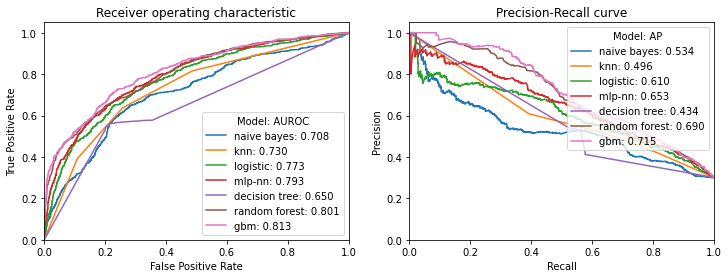

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))    
for column in Pb.columns:
    roc_auc = roc_auc_score(ytest, Pb[column])
    fpr, tpr, _ = roc_curve(ytest, Pb[column])
    ax[0].plot(fpr, tpr, label='%s: %0.3f' % (column, roc_auc))

    precision, recall, _ = precision_recall_curve(ytest, Pb[column])
    ave_prec_rec = average_precision_score(ytest, Pb[column])
    ax[1].plot(recall, precision, label='%s: %0.3f' % (column, ave_prec_rec))  

    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver operating characteristic')
    ax[0].legend(loc="lower right", title="Model: AUROC")

    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall curve')
    ax[1].legend(loc="upper right", title="Model: AP")
   
#plt.savefig('mult_models_after_feat_select.png', format='png')

### Fit important variables into the models

In [22]:
Xtrain2 = df_train[important_vars]
Xtest2 = df_test[important_vars]
ytrain_original = df_train['svc_CYF_ip_30days_postdc_bi']


In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Xtrain2_scaled = scaler.fit_transform(Xtrain2)
Xtest2_scaled = scaler.fit_transform(Xtest2)

In [24]:
# Class Imbalance Processing: Using re-sampling method
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=SEED)
Xtrain2_scaled, ytrain = sm.fit_sample(Xtrain2_scaled, ytrain_original)

In [25]:
models = get_models()
Pm, Sm, model_cvsm = train_predict(models, Xtrain2_scaled, ytrain, Xtest2_scaled)
evaluate(ytest, Sm, Pm)

Fitting models.
naive bayes... Time elapsed  0:00:00.046005
done
knn... Time elapsed  0:00:02.562990
done
logistic... Time elapsed  0:00:00.233004
done
mlp-nn... Time elapsed  0:00:26.620014
done
decision tree... Time elapsed  0:00:00.507004
done
random forest... Time elapsed  0:00:09.178010
done
gbm... Time elapsed  0:00:11.958001
done
Done.

Accuracy : 0.7199
Precision : 0.5506
Recall : 0.3812
F1 score : 0.4505
AUC score : 0.6716
AP score : 0.5259

Classification report : 
               precision    recall  f1-score   support

           0       0.76      0.87      0.81      1953
           1       0.55      0.38      0.45       842

    accuracy                           0.72      2795
   macro avg       0.66      0.62      0.63      2795
weighted avg       0.70      0.72      0.70      2795


Confusion matrix : 
 [[1691  262]
 [ 521  321]]
done.

Accuracy : 0.6572
Precision : 0.4497
Recall : 0.6164
F1 score : 0.5200
AUC score : 0.6872
AP score : 0.4646

Classification report : 
  

(0.47656529516994633,
 0.3530525319451018,
 0.8859857482185273,
 0.5049069373942471,
 0.7507789952238654,
 0.6312119340514771)

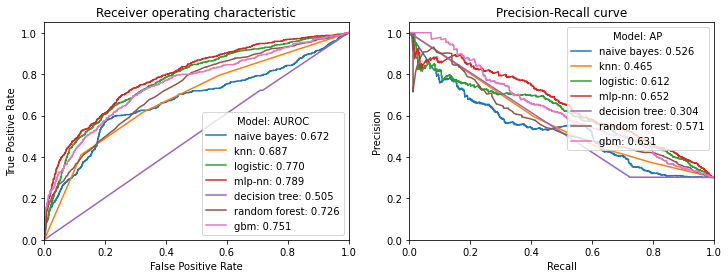

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))    
for column in Pm.columns:
    roc_auc = roc_auc_score(ytest, Pm[column])
    fpr, tpr, _ = roc_curve(ytest, Pm[column])
    ax[0].plot(fpr, tpr, label='%s: %0.3f' % (column, roc_auc))

    precision, recall, _ = precision_recall_curve(ytest, Pm[column])
    ave_prec_rec = average_precision_score(ytest, Pm[column])
    ax[1].plot(recall, precision, label='%s: %0.3f' % (column, ave_prec_rec))  

    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver operating characteristic')
    ax[0].legend(loc="lower right", title="Model: AUROC")

    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall curve')
    ax[1].legend(loc="upper right", title="Model: AP")
   
#plt.savefig('mult_models_after_feat_select.png', format='png')

From the above results, I selected Gradient Boosting as my main model and the set of variables from the Boruta algorithms

## GBM tuning

In [27]:
param1 = {
    "n_estimators":[100,500,1000,1500],
    "learning_rate":[1, 0.1, 0.01, 0.001]
}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1, max_features='sqrt', random_state=SEED), 
            param_grid = param1, scoring='roc_auc',n_jobs=-1, iid=False, cv=5)
tuning.fit(Xtrainb_scaled,ytrain)


C:\Users\Anh Tran\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=4,
                                                  max_features='sqrt',
                                                  random_state=300,
                                                  subsample=1),
             iid=False, n_jobs=-1,
             param_grid={'learning_rate': [1, 0.1, 0.01, 0.001],
                         'n_estimators': [100, 500, 1000, 1500]},
             scoring='roc_auc')

In [28]:
tuning.best_params_, tuning.best_score_

({'learning_rate': 0.1, 'n_estimators': 500}, 0.8805240846477366)

In [29]:
param2 = {
   'max_depth':[2,3,4,5,6,7]
}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.1,n_estimators=500, min_samples_split=2, min_samples_leaf=1, subsample=1, max_features='sqrt', random_state=SEED), 
            param_grid = param2, scoring='roc_auc',n_jobs=-1, iid=False, cv=5)
tuning.fit(Xtrainb_scaled,ytrain)
tuning.best_params_, tuning.best_score_

C:\Users\Anh Tran\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


({'max_depth': 7}, 0.8830776384541276)

In [30]:
new=GradientBoostingClassifier(learning_rate=0.1, n_estimators=500, max_depth=7, max_features='sqrt' , random_state=SEED)
new.fit(Xtrainb_scaled,ytrain)


GradientBoostingClassifier(max_depth=7, max_features='sqrt', n_estimators=500,
                           random_state=300)

In [31]:
y_pred=new.predict(Xtestb_scaled)
y_pred_proba = new.predict_proba(Xtestb_scaled)[:, 1]
y_true = ytest
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1score = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_proba)
ap = average_precision_score(y_true, y_pred_proba)
print ("Accuracy : {:.4f}".format(acc))
print("Precision : {:.4f}".format(precision))
print("Recall : {:.4f}".format(recall))
print("F1 score : {:.4f}".format(f1score))
print("AUC score : {:.4f}".format(auc))
print("AP score : {:.4f}".format(ap))
print("\nClassification report : \n", classification_report(y_true, y_pred))
print("\nConfusion matrix : \n", confusion_matrix(y_true, y_pred))

Accuracy : 0.7789
Precision : 0.6652
Recall : 0.5356
F1 score : 0.5934
AUC score : 0.7824
AP score : 0.6926

Classification report : 
               precision    recall  f1-score   support

           0       0.82      0.88      0.85      1953
           1       0.67      0.54      0.59       842

    accuracy                           0.78      2795
   macro avg       0.74      0.71      0.72      2795
weighted avg       0.77      0.78      0.77      2795


Confusion matrix : 
 [[1726  227]
 [ 391  451]]


as_length_IP                                 0.290714
IP_history                                   0.137052
svc_es_30days_pre                            0.091825
svc_pre_all                                  0.082853
svc_op_30days_pre                            0.082262
svc_pre                                      0.079934
svc_ip_30days_pre                            0.060790
as_loc_IPFFS                                 0.057971
as_loc_IPCAPS                                0.046412
as_close_Home/Shelter/Self                   0.030626
svc_ip_7days_pre                             0.023314
as_close_Satisfactorily Achieved\r\nGoals    0.016247
dtype: float64


Text(0, 0.5, 'Feature Importance Score')

C:\Users\Anh Tran\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Anh Tran\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


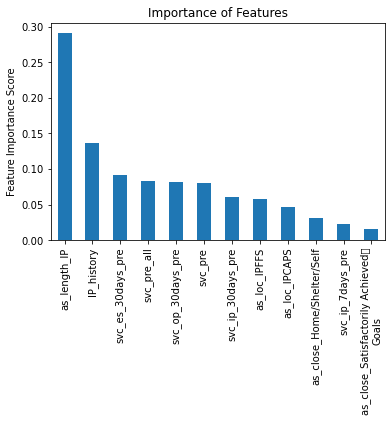

In [32]:
feat_imp = pd.Series(new.feature_importances_, index=Xtrainb.columns).sort_values(ascending=False)
print(feat_imp)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')


In [33]:
models = get_models()
Pb, Sb, model_cvsb = train_predict(models, Xtrainb_scaled, ytrain, Xtestb_scaled)
lr_importances = pd.Series(model_cvsb['logistic'].coef_[0], index=Xtrainb.columns, name = 'LR')
lr_importances_abs = pd.Series(abs(model_cvsb['logistic'].coef_[0]), index=Xtrainb.columns, name = 'LR')
print(lr_importances.sort_values(ascending=False))

Fitting models.
naive bayes... Time elapsed  0:00:00.217812
done
knn... Time elapsed  0:00:01.001147
done
logistic... Time elapsed  0:00:00.161647
done
mlp-nn... Time elapsed  0:00:19.565003
done
decision tree... Time elapsed  0:00:00.310008
done
random forest... Time elapsed  0:00:06.096000
done
gbm... Time elapsed  0:00:06.657001
done
Done.

svc_ip_30days_pre                            4.401424
IP_history                                   2.346932
svc_op_30days_pre                            1.787100
svc_es_30days_pre                            1.096795
svc_pre_all                                  0.642057
as_close_Satisfactorily Achieved\r\nGoals   -0.438637
as_close_Home/Shelter/Self                  -0.628238
svc_pre                                     -1.053096
as_length_IP                                -1.632578
as_loc_IPCAPS                               -1.665435
as_loc_IPFFS                                -1.817746
svc_ip_7days_pre                            -3.465995
Name: 

max_depth = 5 : This should be between 3-10. I’ve started with 5 but you can choose a different number as well. 4-6 can be good starting points.\
min_child_weight = 1 : A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups.\
gamma = 0 : A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later.\
subsample, colsample_bytree = 0.8 : This is a commonly used used start value. Typical values range between 0.5-0.9.\
scale_pos_weight = 1: Because of high class imbalance.

### Archive codes

In [31]:
'''
# impute missing values of categorical features with the most frequent object
for col in categorical_features:
    df[col].fillna(df[col].value_counts().index[0], inplace=True)
'''

'\n# impute missing values of categorical features with the most frequent object\nfor col in categorical_features:\n    df[col].fillna(df[col].value_counts().index[0], inplace=True)\n'

In [32]:
'''
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
'''

"\ngsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,\n min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,\n objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), \n param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)\n"

In [33]:
'''
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',silent=True, nthread=4, 
                    scale_pos_weight=1, random_state=SEED)
grid_search = GridSearchCV(xgb, param_grid = parameters, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
grid_search.fit(Xtrainb_scaled, ytrain)

# retrieve the best parameter set from grid search
print("\nGrid Search Best parameters set :")
print(grid_search.best_params_)
print("\nBest score: %0.3f" % grid_search.best_score_)
time_elapsed = (time.monotonic()-start_time)/60
print("Calculation took %.3f minutes" % time_elapsed)

'''

'\nxgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective=\'binary:logistic\',silent=True, nthread=4, \n                    scale_pos_weight=1, random_state=SEED)\ngrid_search = GridSearchCV(xgb, param_grid = parameters, scoring=\'roc_auc\', n_jobs=4, iid=False, cv=5)\ngrid_search.fit(Xtrainb_scaled, ytrain)\n\n# retrieve the best parameter set from grid search\nprint("\nGrid Search Best parameters set :")\nprint(grid_search.best_params_)\nprint("\nBest score: %0.3f" % grid_search.best_score_)\ntime_elapsed = (time.monotonic()-start_time)/60\nprint("Calculation took %.3f minutes" % time_elapsed)\n\n'

In [34]:
'''
def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        ap = average_precision_score(y, P.loc[:, m])
        print("%-26s: %.3f, %.3f" % (m, score, ap))
    print("Done.\n")
    
def report_models(S, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        report = classification_report(y, S.loc[:, m])
        print(report)
    print("Done.\n")

'''

'\ndef score_models(P, y):\n    """Score model in prediction DF"""\n    print("Scoring models.")\n    for m in P.columns:\n        score = roc_auc_score(y, P.loc[:, m])\n        ap = average_precision_score(y, P.loc[:, m])\n        print("%-26s: %.3f, %.3f" % (m, score, ap))\n    print("Done.\n")\n    \ndef report_models(S, y):\n    """Score model in prediction DF"""\n    print("Scoring models.")\n    for m in P.columns:\n        report = classification_report(y, S.loc[:, m])\n        print(report)\n    print("Done.\n")\n\n'

In [35]:
'''
param3 = {
   'min_samples_split':[4,8,10,20,40,60,80,100], 
    'min_samples_leaf':[1,3,5,7,9]
}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=4, subsample=1,max_features='sqrt', random_state=SEED), 
            param_grid = param3, scoring='accuracy',n_jobs=-1, iid=False, cv=5)
tuning.fit(X_train,y_train)
tuning.grid_scores_, tuning.best_params_, tuning.best_score_

'''

"\nparam3 = {\n   'min_samples_split':[4,8,10,20,40,60,80,100], \n    'min_samples_leaf':[1,3,5,7,9]\n}\n\ntuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=4, subsample=1,max_features='sqrt', random_state=SEED), \n            param_grid = param3, scoring='accuracy',n_jobs=-1, iid=False, cv=5)\ntuning.fit(X_train,y_train)\ntuning.grid_scores_, tuning.best_params_, tuning.best_score_\n\n"